I collected data separetery so there are three types of data.
1. aim to drive on center line.
1. aim to drive from side to center.
1. aim to drive smoothly.

To remove noisy data, I'm going to delete some of data which seem not to fit the trend of each data.
For example,when drive nearby left lane in second method, firstly I approched a lane line and then I steered as I approched a line enough.
So I delete the data which steering value is saved when I approached a lane line.

(This note is completed in 2019/08/22)

In [1]:
import csv
import numpy as np
import pickle
import cv2
from sklearn.model_selection import train_test_split

driving_data_center = []
# Load driving data
with open("/home/nishi/udacity/sim_data_center/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_center.append(data_line)
        
    #endfor
#endwith
driving_data_additional=[]
with open("/home/nishi/udacity/sim_data_additional/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_additional.append(data_line)
        
    #endfor
#endwith

driving_data_left = []
# Load driving data
with open("/home/nishi/udacity/sim_data_recovery_left/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_left.append(data_line)
        
    #endfor
#endwith

with open("/home/nishi/udacity/sim_data_recover_left2/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_left.append(data_line)
        
    #endfor
#endwith

driving_data_right = []
# Load driving data
with open("/home/nishi/udacity/sim_data_recovery_right/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_right.append(data_line)
        
    #endfor
#endwith
"""
with open("/home/nishi/udacity/sim_data_recover_right2/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_right.append(data_line)
        
    #endfor
#endwith
"""

'\nwith open("/home/nishi/udacity/sim_data_recover_right2/driving_log.csv") as csvfile:\n    reader = csv.reader(csvfile)\n    for data_line in reader:\n        driving_data_right.append(data_line)\n        \n    #endfor\n#endwith\n'

the number of driving data on left lane before delete :5909
the number of driving data on left lane after delete :1472
the number of driving data on right lane before delete :4427
the number of driving data on right lane after delete :1466
(10665, 7)
(1472, 7)
(1466, 7)


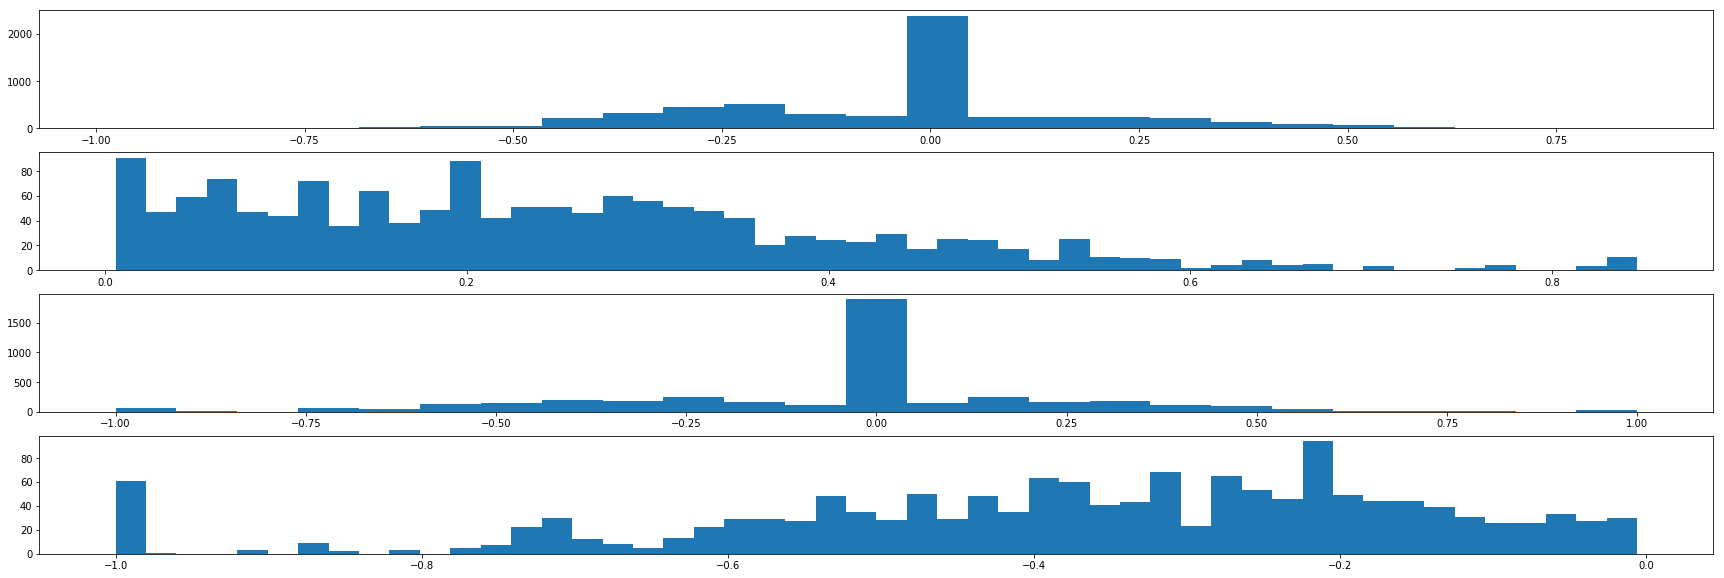

In [2]:
# delete useless data
import matplotlib.pyplot as plt
import random
%matplotlib inline



f,axes = plt.subplots(nrows=4, ncols=1,figsize=(30,10))


# remove noisy data
angle_data = np.array(driving_data_left)[:,3].astype("float")
n, bins, patches = axes[0].hist(angle_data, bins=25)
print("the number of driving data on left lane before delete :"+str(len(driving_data_left)))
noise_left = np.where(np.zeros_like(angle_data)>=angle_data)
driving_data_left=np.delete(driving_data_left,noise_left,axis=0)
print("the number of driving data on left lane after delete :"+str(len(driving_data_left)))


# remove noisy data
angle_data = np.array(driving_data_right)[:,3].astype("float")
n, bins, patches = axes[2].hist(angle_data, bins=25)
print("the number of driving data on right lane before delete :"+str(len(driving_data_right)))
noise_right = np.where(np.zeros_like(angle_data)<=angle_data)
driving_data_right=np.delete(driving_data_right,noise_right,axis=0)
print("the number of driving data on right lane after delete :"+str(len(driving_data_right)))

n, bins, patches = axes[1].hist(driving_data_left[:,3].astype("float"), bins=50)
n, bins, patches = axes[3].hist(driving_data_right[:,3].astype("float"), bins=50)
print(np.shape(driving_data_center))
print(np.shape(driving_data_left))
print(np.shape(driving_data_right))
driving_data=np.concatenate((driving_data_center,driving_data_left,driving_data_right,driving_data_additional),axis=0)
#driving_data=driving_data_center

In [3]:

f1,ax = plt.subplots(nrows=1,ncols=2,figsize=(30,10))
n, bins, patches = ax[0].hist(driving_data[:,3].astype("float"), bins=50)
angle_data = np.array(driving_data)[:,3].astype("float")
n, bins, patches = axes[0].hist(angle_data, bins=25)
print("The mean of samples per bin: ", int(np.mean(n)))
print("the number of driving data before delete :"+str(len(driving_data)))
for i in range(len(n)):
    if n[i] > (np.mean(n)+np.std(n)):
        target = np.squeeze(np.argwhere((bins[i]<=angle_data) & (angle_data<=bins[i+1])))
        driving_data=np.delete(driving_data,random.sample(list(target), len(target)-int(np.mean(n))),axis=0)
print("the number of driving data after delete :"+str(len(driving_data)))
n, bins, patches = ax[1].hist(driving_data[:,3].astype("float"), bins=25)

# split data
train_data, validation_data = train_test_split(driving_data, test_size=0.2) 
print(np.shape(train_data))

(11060, 7)


In [4]:
# split data into image and steer angle
# Generator which is called per batch
from sklearn.utils import shuffle
def driving_data_generator(input_data,batch_size): # this input does not mean network input,just generator's input.
    data_length = len(input_data)
    while 1:
        shuffle(input_data)
        for offset in range(0,data_length,batch_size):
            batch_data = input_data[offset:offset+batch_size]
            # hold network input and ouput data
            images = []
            angles = []
            for data in batch_data:

                for is_flip in range(2):
                    if is_flip == 0:
                        for direction in range(3):
                            name = data[direction]
                            image = cv2.imread(name)
                            images.append(image)
                            if direction == 0:
                                angle = float(data[3])
                            elif direction == 1:
                                angle = float(data[3])+0.1
                            else:
                                angle = float(data[3])-0.1
                            angles.append(angle)
                    elif np.abs(float(data[3])) > 0.05:
                        for direction in range(3):
                            name = data[direction]
                            image = cv2.imread(name)
                            image = np.fliplr(image)
                            images.append(image)
                            if direction == 0:
                                angle = (float(data[3]))*(-1)
                            elif direction == 1:
                                angle = (float(data[3])+0.1)*(-1)
                            else:
                                angle = (float(data[3])-0.1)*(-1)
                            angles.append(angle)

            #endfor
            yield np.array(images),np.array(angles)


In [5]:
# define the model
# this model is based on NVIDIA's Network https://devblogs.nvidia.com/deep-learning-self-driving-cars/
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten,Activation,Cropping2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
import math
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.regularizers import l2

## to avoid my GPU specific error.
import tensorflow as tf
from tensorflow.python.keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))
##

# Set our batch size
batch_size=48
height = 80
width = 320
channel =3
# compile and train the model using the generator function
train_generator = driving_data_generator(train_data, batch_size=batch_size)
validation_generator = driving_data_generator(validation_data, batch_size=batch_size)
# I chose elu as activation funciton ,because the authors said that is best in this paper. (https://arxiv.org/pdf/1511.07289v5.pdf)
model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(height,width,channel)))
model.add(Conv2D(24,kernel_size=(5,5),strides=(2,2), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Conv2D(36,kernel_size=(5,5),strides=(2,2), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(48,kernel_size=(5,5),strides=(2,2), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Conv2D(64,kernel_size=(3,3), activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()
model.compile(loss='mse',optimizer='adam')
model.fit_generator(train_generator,
            steps_per_epoch=math.ceil(len(train_data)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=math.ceil(len(validation_data)/batch_size), 
            epochs=20, verbose=1)

model.save('./model_20190820_ver2.h5')
print("finish!")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 80, 320, 3)        0         
_________________________________________________________________
lambda (Lambda)              (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 38, 158, 24)       1824      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 38, 158, 24)       96        
_________________________________________________________________
dropout (Dropout)            (None, 38, 158, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)    

In [8]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./run_ver2.mp4'))

In [6]:
# define the model
# this model is based on NVIDIA's Network https://devblogs.nvidia.com/deep-learning-self-driving-cars/
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten,Activation,Cropping2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
import math
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.regularizers import l2

## to avoid my GPU specific error.
import tensorflow as tf
from tensorflow.python.keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))
##

# Set our batch size
batch_size=28
height = 80
width = 320
channel =3
# compile and train the model using the generator function
train_generator = driving_data_generator(train_data, batch_size=batch_size)
validation_generator = driving_data_generator(validation_data, batch_size=batch_size)
# I chose elu as activation funciton ,because the authors said that is best in this paper. (https://arxiv.org/pdf/1511.07289v5.pdf)
model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(height,width,channel)))
model.add(Conv2D(24,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(rate=0.2))
model.add(Conv2D(36,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(rate=0.3))
model.add(Conv2D(48,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(rate=0.3))
model.add(Conv2D(64,kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(64,kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(rate=0.5))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(rate=0.5))
model.add(Dense(10))
model.add(Dense(1))
model.summary()
model.compile(loss='mse',optimizer='adam')
model.fit_generator(train_generator,
            steps_per_epoch=math.ceil(len(train_data)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=math.ceil(len(validation_data)/batch_size), 
            epochs=20, verbose=1)

model.save('./model_20190820_ver2_modified.h5')
print("finish!")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 80, 320, 3)        0         
_________________________________________________________________
lambda (Lambda)              (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 38, 158, 24)       1824      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 38, 158, 24)       96        
_________________________________________________________________
activation (Activation)      (None, 38, 158, 24)       0         
_________________________________________________________________
dropout (Dropout)    

393/393 [==============================] - 92s 235ms/step - loss: 0.0150 - val_loss: 0.0124
Epoch 16/20
393/393 [==============================] - 93s 236ms/step - loss: 0.0149 - val_loss: 0.0120
Epoch 17/20
393/393 [==============================] - 92s 235ms/step - loss: 0.0146 - val_loss: 0.0124
Epoch 18/20
393/393 [==============================] - 93s 236ms/step - loss: 0.0144 - val_loss: 0.0122
Epoch 19/20
393/393 [==============================] - 92s 235ms/step - loss: 0.0143 - val_loss: 0.0121
Epoch 20/20
393/393 [==============================] - 92s 235ms/step - loss: 0.0141 - val_loss: 0.0120
finish!


In [13]:
# define the model
# this model is based on NVIDIA's Network https://devblogs.nvidia.com/deep-learning-self-driving-cars/
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten,Activation,Cropping2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
import math
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.regularizers import l2

## to avoid my GPU specific error.
import tensorflow as tf
from tensorflow.python.keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))
##

# Set our batch size
batch_size=28
height = 70
width = 320
channel =3
# compile and train the model using the generator function
train_generator = driving_data_generator(train_data, batch_size=batch_size)
validation_generator = driving_data_generator(validation_data, batch_size=batch_size)
# I chose elu as activation funciton ,because the authors said that is best in this paper. (https://arxiv.org/pdf/1511.07289v5.pdf)
model = Sequential()
model.add(Cropping2D(cropping=((70,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(height,width,channel)))
model.add(Conv2D(24,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(36,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(48,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(64,kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(64,kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Flatten())
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dense(10))
model.add(Dense(1))
model.summary()
model.compile(loss='mse',optimizer='adam')
model.fit_generator(train_generator,
            steps_per_epoch=math.ceil(len(train_data)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=math.ceil(len(validation_data)/batch_size), 
            epochs=10,callbacks=[EarlyStopping(patience=2)], verbose=1)

model.save('./model_20190820_without_dropout.h5')
print("finish!")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 158, 24)       1824      
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 33, 158, 24)       96        
_________________________________________________________________
activation_7 (Activation)    (None, 33, 158, 24)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 15, 77, 36)        144       
__________

In [5]:
# define the model
# this model is based on NVIDIA's Network https://devblogs.nvidia.com/deep-learning-self-driving-cars/
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten,Activation,Cropping2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
import math
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.regularizers import l2

## to avoid my GPU specific error.
import tensorflow as tf
from tensorflow.python.keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))
##

# Set our batch size
batch_size=28
height = 70
width = 320
channel =3
# compile and train the model using the generator function
train_generator = driving_data_generator(train_data, batch_size=batch_size)
validation_generator = driving_data_generator(validation_data, batch_size=batch_size)
# I chose elu as activation funciton ,because the authors said that is best in this paper. (https://arxiv.org/pdf/1511.07289v5.pdf)
model = Sequential()
model.add(Cropping2D(cropping=((70,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(height,width,channel)))
model.add(Conv2D(24,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(36,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(48,kernel_size=(5,5),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(64,kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(64,kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Flatten())
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dense(10))
model.add(Dense(1))
model.summary()
model.compile(loss='mse',optimizer='adam')
model.fit_generator(train_generator,
            steps_per_epoch=math.ceil(len(train_data)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=math.ceil(len(validation_data)/batch_size), 
            epochs=10,callbacks=[EarlyStopping(patience=2)], verbose=1)

model.save('./model_without_distribution_change.h5')
print("finish!")

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 70, 320, 3)        0         
_________________________________________________________________
lambda (Lambda)              (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 33, 158, 24)       1824      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 33, 158, 24)       96        
_________________________________________________________________
activation (Activation)      (None, 33, 158, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
batc

### Set the parameter which express the ratio of data derived from each data-set.

alpha: the number of data driving in side lane / the number of data driving in center lane.


In [4]:
import csv
import numpy as np
import pickle
import cv2
from sklearn.model_selection import train_test_split
alpha = np.arange(2,10,1)/10
driving_data_center = []
# Load driving data
with open("/home/nishi/udacity/sim_data_center/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_center.append(data_line)
        
    #endfor
#endwith
"""
driving_data_additional=[]
with open("/home/nishi/udacity/sim_data_additional/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_additional.append(data_line)
        
    #endfor
#endwith
"""

driving_data_left = []
# Load driving data
with open("/home/nishi/udacity/sim_data_recovery_left/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_left.append(data_line)
        
    #endfor
#endwith

with open("/home/nishi/udacity/sim_data_recover_left2/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_left.append(data_line)
        
    #endfor
#endwith

driving_data_right = []
# Load driving data
with open("/home/nishi/udacity/sim_data_recovery_right/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_right.append(data_line)
        
    #endfor
#endwith
"""
with open("/home/nishi/udacity/sim_data_recover_right2/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for data_line in reader:
        driving_data_right.append(data_line)
        
    #endfor
#endwith
"""

'\nwith open("/home/nishi/udacity/sim_data_recover_right2/driving_log.csv") as csvfile:\n    reader = csv.reader(csvfile)\n    for data_line in reader:\n        driving_data_right.append(data_line)\n        \n    #endfor\n#endwith\n'

the number of driving data on left lane before delete :5909
the number of driving data on left lane after delete :1472
the number of driving data on right lane before delete :4427
the number of driving data on right lane after delete :1466
(10665, 7)
(1472, 7)
(1466, 7)


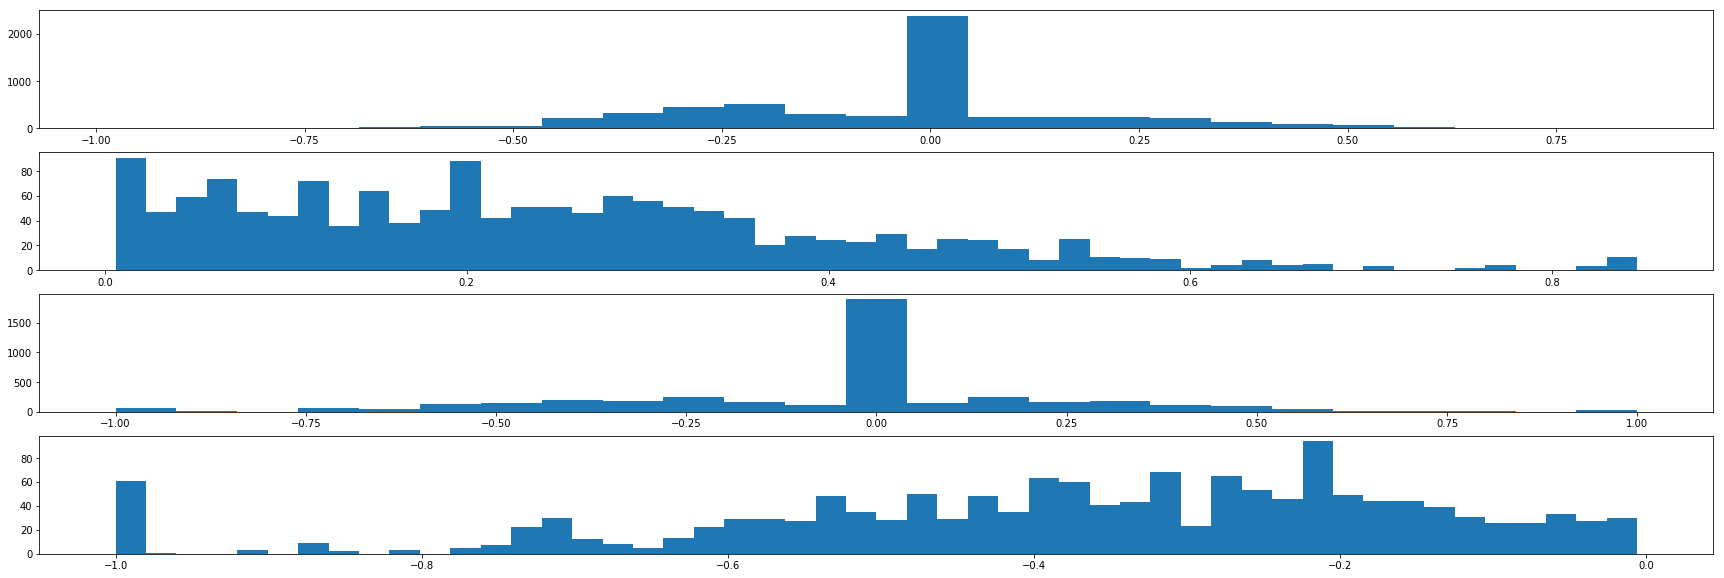

In [2]:
# delete useless data
import matplotlib.pyplot as plt
import random
%matplotlib inline



f,axes = plt.subplots(nrows=4, ncols=1,figsize=(30,10))


# remove noisy data
angle_data = np.array(driving_data_left)[:,3].astype("float")
n, bins, patches = axes[0].hist(angle_data, bins=25)
print("the number of driving data on left lane before delete :"+str(len(driving_data_left)))
noise_left = np.where(np.zeros_like(angle_data)>=angle_data)
driving_data_left=np.delete(driving_data_left,noise_left,axis=0)
print("the number of driving data on left lane after delete :"+str(len(driving_data_left)))


# remove noisy data
angle_data = np.array(driving_data_right)[:,3].astype("float")
n, bins, patches = axes[2].hist(angle_data, bins=25)
print("the number of driving data on right lane before delete :"+str(len(driving_data_right)))
noise_right = np.where(np.zeros_like(angle_data)<=angle_data)
driving_data_right=np.delete(driving_data_right,noise_right,axis=0)
print("the number of driving data on right lane after delete :"+str(len(driving_data_right)))

n, bins, patches = axes[1].hist(driving_data_left[:,3].astype("float"), bins=50)
n, bins, patches = axes[3].hist(driving_data_right[:,3].astype("float"), bins=50)
print(np.shape(driving_data_center))
print(np.shape(driving_data_left))
print(np.shape(driving_data_right))


In [6]:
# define the model
# this model is based on NVIDIA's Network https://devblogs.nvidia.com/deep-learning-self-driving-cars/
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten,Activation,Cropping2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
import math
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import load_model

## to avoid my GPU specific error.
import tensorflow as tf
from tensorflow.python.keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))
##
for i in range(len(alpha)):
    print(len(driving_data_center))
    print(len(driving_data_center)-len(driving_data_left)/alpha[i])
    driving_data_center_modified=np.delete(driving_data_center,random.sample(list(np.arange(len(driving_data_center))), int(len(driving_data_center)-len(driving_data_left)/alpha[i])),axis=0)
    driving_data=np.concatenate((driving_data_center_modified,driving_data_left,driving_data_right),axis=0)
    # split data
    train_data, validation_data = train_test_split(driving_data, test_size=0.2) 

    # Set our batch size
    batch_size=28
    height = 70
    width = 320
    channel =3
    # compile and train the model using the generator function
    train_generator = driving_data_generator(train_data, batch_size=batch_size)
    validation_generator = driving_data_generator(validation_data, batch_size=batch_size)
    model = load_model('./model_20190820_without_dropout.h5')
    for j in range(len(model.layers)-2):
        model.layers[j].trainable=False
    #endfor

    model.summary()
    model.compile(loss='mse',optimizer='adam')
    model.fit_generator(train_generator,
                steps_per_epoch=math.ceil(len(train_data)/batch_size), 
                validation_data=validation_generator, 
                validation_steps=math.ceil(len(validation_data)/batch_size), 
                epochs=10,callbacks=[EarlyStopping(patience=2)], verbose=1)

    model.save('./model_alpha_{0}.h5'.format(alpha[i]*10))
    print("{0}/8 finish!".format(i+1))

10665
3305.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 158, 24)       1824      
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 33, 158, 24)       96        
_________________________________________________________________
activation_7 (Activation)    (None, 33, 158, 24)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 15, 77, 36)        144     

Epoch 1/10
225/225 [==============================] - 122s 540ms/step - loss: 0.0224 - val_loss: 0.0200
Epoch 2/10
225/225 [==============================] - 113s 504ms/step - loss: 0.0218 - val_loss: 0.0199
Epoch 3/10
225/225 [==============================] - 116s 514ms/step - loss: 0.0217 - val_loss: 0.0198
Epoch 4/10
225/225 [==============================] - 115s 509ms/step - loss: 0.0216 - val_loss: 0.0197
Epoch 5/10
225/225 [==============================] - 114s 508ms/step - loss: 0.0216 - val_loss: 0.0197
Epoch 6/10
225/225 [==============================] - 115s 509ms/step - loss: 0.0216 - val_loss: 0.0196
Epoch 7/10
225/225 [==============================] - 113s 504ms/step - loss: 0.0216 - val_loss: 0.0196
Epoch 8/10
225/225 [==============================] - 114s 508ms/step - loss: 0.0215 - val_loss: 0.0196
Epoch 9/10
225/225 [==============================] - 114s 508ms/step - loss: 0.0215 - val_loss: 0.0195
Epoch 10/10
225/225 [==============================] - 114s 508m

Epoch 1/10
169/169 [==============================] - 99s 585ms/step - loss: 0.0271 - val_loss: 0.0246
Epoch 2/10
169/169 [==============================] - 89s 529ms/step - loss: 0.0263 - val_loss: 0.0237
Epoch 3/10
169/169 [==============================] - 90s 531ms/step - loss: 0.0258 - val_loss: 0.0237
Epoch 4/10
169/169 [==============================] - 89s 527ms/step - loss: 0.0257 - val_loss: 0.0237
Epoch 5/10
169/169 [==============================] - 89s 527ms/step - loss: 0.0257 - val_loss: 0.0237
4/8 finish!
10665
8211.666666666666
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 158, 24)     

Epoch 1/10
144/144 [==============================] - 89s 616ms/step - loss: 0.0280 - val_loss: 0.0305
Epoch 2/10
144/144 [==============================] - 77s 535ms/step - loss: 0.0277 - val_loss: 0.0304
Epoch 3/10
144/144 [==============================] - 78s 543ms/step - loss: 0.0276 - val_loss: 0.0304
Epoch 4/10
144/144 [==============================] - 77s 536ms/step - loss: 0.0276 - val_loss: 0.0303
Epoch 5/10
144/144 [==============================] - 78s 543ms/step - loss: 0.0275 - val_loss: 0.0303
Epoch 6/10
144/144 [==============================] - 78s 540ms/step - loss: 0.0275 - val_loss: 0.0303
Epoch 7/10
144/144 [==============================] - 77s 538ms/step - loss: 0.0275 - val_loss: 0.0303
Epoch 8/10
144/144 [==============================] - 78s 540ms/step - loss: 0.0275 - val_loss: 0.0302
Epoch 9/10
144/144 [==============================] - 79s 548ms/step - loss: 0.0275 - val_loss: 0.0302
Epoch 10/10
144/144 [==============================] - 86s 595ms/step - l

Epoch 1/10
131/131 [==============================] - 74s 562ms/step - loss: 0.0302 - val_loss: 0.0336
Epoch 2/10
131/131 [==============================] - 58s 443ms/step - loss: 0.0297 - val_loss: 0.0334
Epoch 3/10
131/131 [==============================] - 58s 446ms/step - loss: 0.0295 - val_loss: 0.0334
Epoch 4/10
131/131 [==============================] - 59s 448ms/step - loss: 0.0294 - val_loss: 0.0334
Epoch 5/10
131/131 [==============================] - 58s 446ms/step - loss: 0.0294 - val_loss: 0.0334
Epoch 6/10
131/131 [==============================] - 58s 445ms/step - loss: 0.0294 - val_loss: 0.0334
Epoch 7/10
131/131 [==============================] - 59s 450ms/step - loss: 0.0293 - val_loss: 0.0333
Epoch 8/10
131/131 [==============================] - 58s 443ms/step - loss: 0.0293 - val_loss: 0.0333
Epoch 9/10
131/131 [==============================] - 58s 445ms/step - loss: 0.0293 - val_loss: 0.0333
Epoch 10/10
131/131 [==============================] - 58s 446ms/step - l

In [3]:
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.models import load_model
model = load_model('./model_20190820_without_dropout.h5')
plot_model(model, to_file='model.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


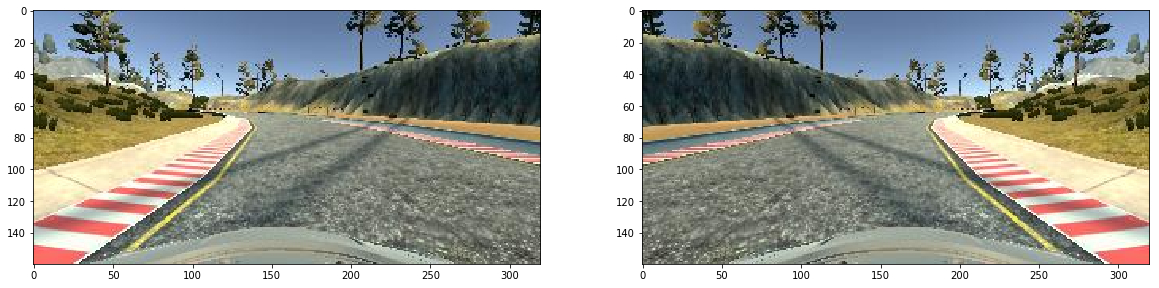

In [11]:
import cv2
import matplotlib.pyplot as plt
name = "../sim_data_recovery_left/IMG/center_2019_08_20_17_46_30_143.jpg"
image = cv2.cvtColor(cv2.imread(name),cv2.COLOR_BGR2RGB)
image_flip = np.fliplr(image)
f,ax = plt.subplots(nrows = 1,ncols=2,figsize= (20,10))
ax[0].imshow(image)
ax[1].imshow(image_flip)
f.savefig("flip.png")